In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random


In [6]:

# 데이터셋 폴더 경로 설정
data_folder = "C:/Workspace/LAB_DP/Week4/train"
test_folder = "C:/Workspace/LAB_DP/Week4/test"

# 데이터 전처리를 위한 변환 함수 정의
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_id = int(img_name[:4]) - 1  # 이미지 파일명의 첫 네 자리 숫자를 ID로 사용
        img_path = os.path.join(self.data_folder, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, img_id

# 사용자 정의 데이터셋 클래스 생성
custom_dataset = CustomDataset(data_folder, transform)
#custom_testset = CustomDataset(test_folder, transform)

# 데이터셋 분할 (예시로 80% train, 10% test, 10% validation)
# 시드값 고정
random.seed(42)
train_size = int(0.8 * len(custom_dataset))
val_size = (len(custom_dataset) - train_size) // 2
test_size = (len(custom_dataset) - train_size) - val_size
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])
#val_size = (len(custom_dataset) - train_size)
#train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
#test_dataset = custom_testset

# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


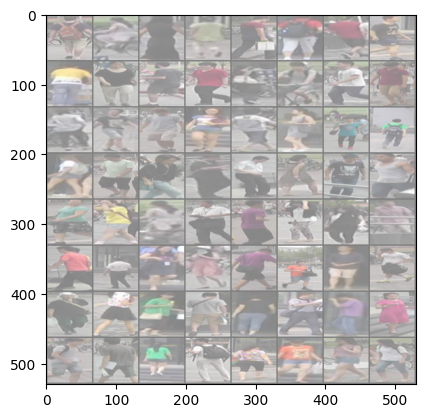

In [7]:

def imshow(img):
    img = img / 2 + 0.5  # 비정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# train_loader에서 하나의 미니배치 추출
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지 시각화
imshow(torchvision.utils.make_grid(images))


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cuda.matmul.allow_tf32 = True

# ResNet-18 모델 불러오기
model = models.resnet18(pretrained=False)  # 사전 훈련된 가중치를 사용하지 않음 (랜덤 초기화)
num_classes = 1501  # 데이터셋의 클래스 개수에 맞게 수정
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 학습 함수 구현
def train(model, epoch, optimizer, loss_function, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    for e in range(epoch):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {e+1}/{epoch}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {e+1}/{epoch}, Loss: {epoch_loss:.4f}")

        # Validation 정확도 계산
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # GPU 메모리 정리
        torch.cuda.empty_cache()

# Test 함수 구현
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

# 모델 학습
learning_rate = 0.001
epoch = 10
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, epoch, optimizer, loss_function, train_loader, val_loader)

# 테스트 데이터로 모델 평가
test(model, test_loader)


cuda


Epoch 1/10: 100%|██████████| 326/326 [00:27<00:00, 11.98it/s]


Epoch 1/10, Loss: 7.0080
Validation Accuracy: 1.50%


Epoch 2/10: 100%|██████████| 326/326 [00:26<00:00, 12.20it/s]


Epoch 2/10, Loss: 5.2263
Validation Accuracy: 15.20%


Epoch 3/10: 100%|██████████| 326/326 [00:26<00:00, 12.23it/s]


Epoch 3/10, Loss: 3.2673
Validation Accuracy: 15.62%


Epoch 4/10: 100%|██████████| 326/326 [00:26<00:00, 12.21it/s]


Epoch 4/10, Loss: 2.0497
Validation Accuracy: 36.08%


Epoch 5/10: 100%|██████████| 326/326 [00:26<00:00, 12.28it/s]


Epoch 5/10, Loss: 1.2758
Validation Accuracy: 46.18%


Epoch 6/10: 100%|██████████| 326/326 [00:26<00:00, 12.27it/s]


Epoch 6/10, Loss: 0.7949
Validation Accuracy: 57.31%


Epoch 7/10: 100%|██████████| 326/326 [00:26<00:00, 12.24it/s]


Epoch 7/10, Loss: 0.4797
Validation Accuracy: 60.58%


Epoch 8/10: 100%|██████████| 326/326 [00:26<00:00, 12.28it/s]


Epoch 8/10, Loss: 0.3110
Validation Accuracy: 63.53%


Epoch 9/10: 100%|██████████| 326/326 [00:26<00:00, 12.24it/s]


Epoch 9/10, Loss: 0.2088
Validation Accuracy: 57.43%


Epoch 10/10: 100%|██████████| 326/326 [00:27<00:00, 12.07it/s]


Epoch 10/10, Loss: 0.1293
Validation Accuracy: 65.22%
Test Accuracy: 65.66%
